In [205]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    sys.path.append(r'C:\_Lib\python')
    from BEMHelper import interpolate_slow
    from slab.circuitqed import SingleElectron
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

# Gaussian blur due to a moving cavity frequency

In this notebook I work out what the impact of a moving cavity peak is on the averaged voltage sweep. In our experiment, the cavity frequency moves, because of the resonantor electrons, and helium vibrations on the resonator. The question is whether the presence of these electrons can be treated as a constant background on our signal, or if the signal due to the single electron is affected or maybe even obscured by these vibrations. As we will find out, the presence of the electrons will not affect the phase signal as long as 

$$\Delta_\mathrm{drive} = f_\mathrm{drive} - f_\mathrm{cavity} (t) \ll \kappa$$ 

where $\kappa$ is the cavity linewidth. Note that we assume here no explicit time dependence of the electron frequency. The frequency jitter in the electron mode frequency is present in the $\Gamma$. 

In [262]:
# this assumes kappa ~ 0.5 kappa_in + 0.5 kappa_out (no internal loss)
g_guess = 5E6
gamma_guess = 150E6

f_cavity = 6.397E9
detunings = np.linspace(-1.0E6, 1.0E6, 151)
detuning_std = 300e3 #kappa_tot
f_drive = f_cavity + detunings
Q_cavity = 20E3
kappa_tot = f_cavity / Q_cavity
Vtrap = np.linspace(0.150, 0.200,10000)

def detuning_distribution(detunings, std, mean=0):
    return 1 / np.sqrt(2 * np.pi * std**2) * np.exp(-(detunings - mean) ** 2 / (2 * std **2))

def V2f(V, Vstart, Vcrossing, f_cavity):
    return f_cavity * np.sqrt(V - Vstart) / np.sqrt(Vcrossing - Vstart)

def susceptibility(g, f_drive, f_electron, gamma):
    return (2 * np.pi * g) ** 2 / (2 * np.pi * (f_drive - f_electron) + 1j * 2 * np.pi * gamma)
    
def btbin(kappa_tot, g, cavity_drive_detuning_points, cavity_drive_detuning_sigma, f_drive, f_electron, gamma):
    susc = susceptibility(g, f_drive, f_electron, gamma)
    detuning_possibility = detuning_distribution(cavity_drive_detuning_points, cavity_drive_detuning_sigma)
    phases_s21 = np.zeros((len(cavity_drive_detuning_points), len(f_electron)))
    mags_s21 = np.zeros((len(cavity_drive_detuning_points), len(f_electron)))
    for k, cavity_drive_detuning in enumerate(cavity_drive_detuning_points):
        single_response = 2 * np.pi * kappa_tot / (2 * np.pi * cavity_drive_detuning - susc + 1j * 2 * np.pi * kappa_tot)
        if len(detuning_possibility) == 1:
            detuning_possibility[0] = 1.0
            detuning_step = 1.0
        else:
            detuning_step = np.diff(cavity_drive_detuning_points)[0]
            
        phases_s21[k, :] = np.arctan2(-np.imag(single_response), np.real(single_response)) * detuning_possibility[k] * detuning_step
        mags_s21[k, :] = (np.abs(single_response) - 1) * detuning_possibility[k] * detuning_step
    
    phase_s21 = np.sum(phases_s21, axis=0)
    mag_s21 = 1 + np.sum(mags_s21, axis=0)
    
    return mag_s21, phase_s21-np.pi/2.

To simulate the moving cavity peak we assume $\Delta_\mathrm{drive}$ has a Gaussian distribution with mean 0 and standard deviation $\sigma_\Delta$: 

$$ P(\Delta_\mathrm{drive}) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( \frac{\Delta_\mathrm{drive}^2}{2\sigma^2} \right)$$

We take the weights corresponding to each of the $\Delta$ into account when we average over the different voltage sweeps. A sample distribution is given below:

PDF is normalized : 0.999


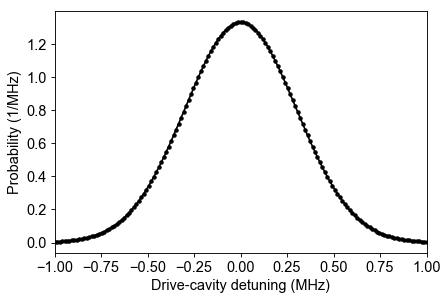

In [263]:
fig = plt.figure()
common.configure_axes(13)

plt.plot(detunings/1E6, detuning_distribution(detunings, std=detuning_std) * 1E6, '.-k')
plt.xlim(np.min(detunings)/1e6, np.max(detunings)/1e6)
plt.xlabel("Drive-cavity detuning (MHz)")
plt.ylabel("Probability (1/MHz)")

print('PDF is normalized : %.3f' % np.sum(detuning_distribution(detunings, std=detuning_std) * np.diff(detunings)[0]))

In addition, we need to know the voltage to electron frequency conversion. We estimate this dependence as follows. If the curvature is positive, the frequency must obey a square root dependence on the electrode voltage. We can then parametrize the dependence with three parameters, $V_\mathrm{start}$ (voltage at which there is no curvature), $V_\mathrm{crossing}$ and $f_\mathrm{crossing}$ (the frequency at which $f (V_\mathrm{crossing}) = f_\mathrm{crossing}$).

The voltage to electron frequency conversion is then given by the formula:

$$f_\mathrm{electron}(V) = \frac{f_\mathrm{crossing}}{\sqrt{V_\mathrm{crossing} - V_\mathrm{start}}} \sqrt{V - V_\mathrm{start}} $$

$V_\mathrm{crossing}. f_\mathrm{crossing}$ may be any point on the curve, but from an experiment the only obvious point is where the electron frequency crosses the resonator. And so we take $f_\mathrm{crossing} = f_\mathrm{cavity}$ and assume we are quite good at determining the voltage at which the electron mode frequency crosses the resonantor. 

The start voltage $V_\mathrm{start}$ is harder to determine from experiment. And in most cases it's clear that the sweep doesn't go all the way to $f_\mathrm{electron} = 0$. Therefore, the response below the crossing is quite inaccurate.

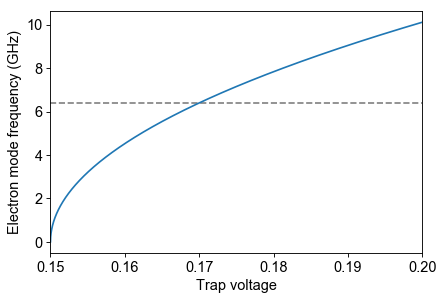

In [264]:
plt.plot(Vtrap, 1/1E9 * V2f(Vtrap, Vstart=0.150, Vcrossing=0.170, f_cavity=f_cavity))
plt.xlabel("Trap voltage")
plt.ylabel("Electron mode frequency (GHz)")
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.hlines(f_cavity / 1E9, np.min(Vtrap), np.max(Vtrap), linestyles='--', color='gray')

We now calculate the cavity output according to the input-output theory for two cases:
* The drive-cavity detuning has a Gaussian distribution with the standard deviation specified above
* The drive-cavity detuning is zero (this is the ideal situation in which the electrons on the resonator wouldn't move)

Note that in principle the cavity response can be approximated by the following formulas: 

$$ \Delta \phi \approx \frac{\mathrm{Re} (\chi (\omega_0))}{\kappa_{tot}} $$ 
$$ |S_{21}| \approx \frac{\mathrm{Im} (\chi (\omega_0))}{\kappa_{tot}} $$ 

But this only works well if 
* you drive exactly on resonance: there is no detuning between the drive and the cavity 
* the change in $\kappa_{tot}$ due to the electron is small compared to $\kappa_{tot}$. Essentially this means $\Gamma, \kappa > g$. 

Both cases are easily violated in our experiment, and therefore we must use the full expression derived from input-output theory. 

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


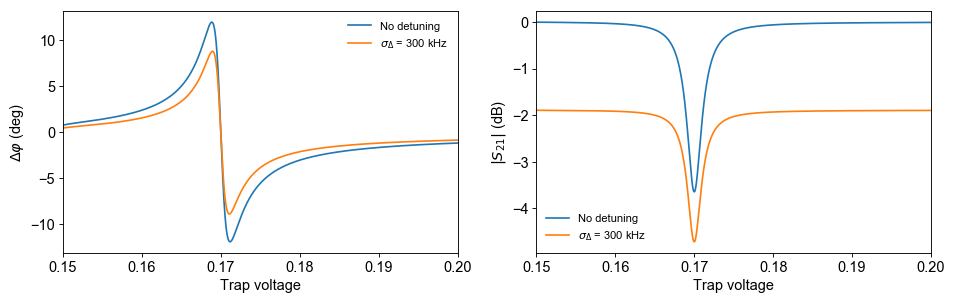

In [265]:
# With detuning (sigma specified above)
s21_mag_full, s21_phi_full = btbin(kappa_tot=kappa_tot, g=g_guess, 
                                   cavity_drive_detuning_points=detunings, 
                                   cavity_drive_detuning_sigma=detuning_std, f_drive=f_cavity, 
                                   f_electron=V2f(Vtrap, Vstart=0.150, Vcrossing=0.170, f_cavity=f_cavity), 
                                   gamma=gamma_guess)

# No detuning
s21_mag_no_det, s21_phi_no_det = btbin(kappa_tot=kappa_tot, g=g_guess, 
                                       cavity_drive_detuning_points=np.array([0]), 
                                       cavity_drive_detuning_sigma=0.0E6, f_drive=f_cavity, 
                                       f_electron=V2f(Vtrap, Vstart=0.150, Vcrossing=0.170, f_cavity=f_cavity), 
                                       gamma=gamma_guess)

plt.figure(figsize=(14.,4.))
plt.subplot(121)
plt.plot(Vtrap, s21_phi_no_det * 180/np.pi, label="No detuning")
plt.plot(Vtrap, s21_phi_full * 180/np.pi, label="$\sigma_\Delta$ = %.0f kHz" % (detuning_std/1E3))
plt.xlabel("Trap voltage")
plt.ylabel(r"$\Delta \varphi$ (deg)")
plt.legend(loc=0, prop={"size" : 10}, frameon=False)
plt.xlim(np.min(Vtrap), np.max(Vtrap))

plt.subplot(122)
plt.plot(Vtrap, 20 * np.log10(s21_mag_no_det), label="No detuning")
plt.plot(Vtrap, 20 * np.log10(s21_mag_full), label="$\sigma_\Delta$ = %.0f kHz" % (detuning_std/1E3))
plt.xlabel("Trap voltage")
plt.ylabel(r"$|S_{21}|$ (dB)")
plt.xlim(np.min(Vtrap), np.max(Vtrap))

plt.legend(loc=0, prop={"size" : 10}, frameon=False)


It is clear that the movement of the cavity frequency doesn't affect the *phase* too much. The *magnitude* of the signal is more affected by the movement of the cavity frequency w.r.t. the drive tone. This is because the magnitude varies with varying $\Delta$, another way of putting this is that $$ \frac{d |S_{21}|}{d \Delta} \neq \mathrm{constant}$$ whereas
$$\frac{d \varphi}{d \Delta} = \frac{d}{d\Delta} \arctan \left( \frac{2\Delta}{\kappa} \right) \approx \frac{2}{\kappa} = \mathrm{constant}$$